In [5]:
import warnings
import logging


warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [6]:
from utils import make_environments
from utils import pearl_utils
from configs.defaults import forecasting_model_path
from configs.defaults import target_pair
from utils.reward_functions import log_reward_function,cumulative_reward_function,sharpe_reward_function
from utils. utils import make_hidden_dims
import optuna
from optuna.samplers import TPESampler
from neuralforecast.core import NeuralForecast
from Pearl.pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from Pearl.pearl.utils.functional_utils.train_and_eval.online_learning import \
    online_learning
import datetime

In [7]:
# model=NeuralForecast.load('MultiHeadForecastingModel/')

Seed set to 6
Seed set to 19
Seed set to 16


['data/binanceus-DOGEUSDT-1h.pkl']


100%|██████████| 78/78 [00:00<00:00, 11054.05it/s]
1it [00:00, 17.52it/s]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

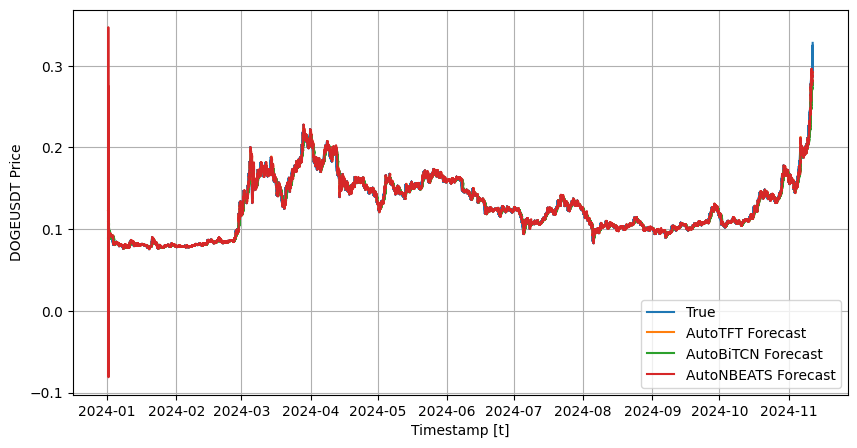

In [8]:
reward_functions=[log_reward_function,cumulative_reward_function,sharpe_reward_function]
train_env,test_env=make_environments.make_envs(reward_function=log_reward_function)


In [9]:
sp=train_env.positions
train_env.action_space.n

np.int64(2)

In [10]:
make_hidden_dims(n_layers=3, n_units=64)

[64, 64, 64]

In [11]:
agent=pearl_utils.create_ddqn_model(

        observation_space_dim=train_env.observation_space.shape[0], 
        action_space_dim=train_env.action_space.n,
        hidden_dims=[64,64, 64], 
        training_rounds=20,
        learning_rate = 0.001,
        discount_factor = 0.99,
        batch_size = 128,
        target_update_freq = 10,
        soft_update_tau = 0.75,  # a value of 1 indicates no soft updates
        is_conservative = False,
        conservative_alpha = False,
        replay_buffer_size = 10_000,
        lstm=False)

In [12]:
test_env.observation_space.shape,train_env.action_space.n

((30,), np.int64(2))

In [13]:
env=GymEnvironment(train_env)

obs,action_space=env.reset()
agent.reset(   obs, action_space)

In [14]:
# done = False
# while not done:
#     action = agent.act(exploit=False)
#     action_result = env.step(action)
    
#     agent.observe(action_result)
#     loss=agent.learn()

#     done = action_result.done

In [15]:
info = online_learning(
        agent=agent,
        env=env,
        # number_of_episodes=10,
        number_of_steps=168,
        print_every_x_episodes=2,   # print returns after every 10 episdoes
        print_every_x_steps=1,   # print returns after every 10 episdoes
        learn_every_k_steps=20,   # print returns after every 10 episdoes
        learn_after_episode=False,
        record_period=169,   # instead of updating after every environment interaction, Q networks are updates at the end of each episode
        seed=0
    )

  0%|          | 0/168 [00:00<?, ?it/s]

In [16]:
33//1

33

In [ ]:


def objective_function(trial):
 
    reward_id=trial.suggest_categorical('reward_function', [0,1,2])
    algo=trial.suggest_categorical('algorithm', ['dqn','ddqn'])    

    # reward_id=0
    
    reward_func=reward_functions[reward_id]
    train_env.reward_func=reward_func
    test_env.reward_func=reward_func
    
    observation_space_dim=train_env.observation_space.shape[0]
    action_space_dim=len(train_env.positions)
    n_layers=trial.suggest_int('n_layers', 1, 3)
    n_units=trial.suggest_categorical('n_units', [64,128,256,512])
    
    hidden_dims=make_hidden_dims(n_layers= n_layers, n_units=n_units)
    
    search_space={
                'observation_space_dim': observation_space_dim,
                'action_space_dim': action_space_dim,
                'hidden_dims': hidden_dims,
                'training_rounds': trial.suggest_int('training_rounds', 5, 30),
                'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-4),
                'discount_factor': trial.suggest_float('discount_factor', 0.8, 0.99), # gamma (greediness)
                'batch_size': trial.suggest_categorical('batch_size', [64, 128]),
                'target_update_freq': trial.suggest_categorical('target_update_freq', [1, 5, 10, 24]),
                'soft_update_tau': trial.suggest_float('soft_update_tau', 0.1, .99), 
                'is_conservative': trial.suggest_categorical('is_conservative', [True, False]),
                'lstm': trial.suggest_categorical('lstm', [True, False]),
                'conservative_alpha': trial.suggest_float('conservative_alpha', 0.5, 1.0),
                }

    learning_space={'learn_after_episode':trial.suggest_categorical('learn_after_episode', [True, False]),
                    'learning_steps':trial.suggest_int('learning_steps', 10, 89),
                    'n_epochs':trial.suggest_categorical('n_epochs',[100,500]),
                    }
    #
    # print('n_epochs',n_epochs)
    if algo=='dqn':
        agent=pearl_utils.create_dqn_model(**search_space)
    elif algo=='ddqn':
        agent=pearl_utils.create_ddqn_model(**search_space)

        
    agent=pearl_utils.train_pearl_model(agent,train_env,**learning_space)
    profit,n_trades=pearl_utils.test_pearl_model(agent,test_env)

    print('profit',profit,'n_trades',n_trades)
    return profit ,n_trades

In [20]:
today=datetime.datetime.now().strftime('%Y-%m-%d')
study = optuna.create_study(study_name=f"pearl-{today}-hp-search",
                            directions=["maximize", "maximize"],
                            storage="sqlite:///pearl_hyper_parameters.sqlite3",
                            load_if_exists=True,
                            sampler=TPESampler()
                            )


[I 2024-11-12 10:38:35,260] A new study created in RDB with name: pearl-2024-11-12-hp-search


In [21]:
study.optimize(objective_function, n_trials=100)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:52<?, ?it/s]
[I 2024-11-12 10:39:32,215] Trial 0 finished with values: [1014.6908545789883, 90.96] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 64, 'training_rounds': 22, 'learning_rate': 9.231821479433793e-05, 'discount_factor': 0.9678721884910304, 'batch_size': 128, 'target_update_freq': 1, 'soft_update_tau': 0.5988514092907152, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.6171898128620397, 'learn_after_episode': False, 'learning_steps': 68, 'n_epochs': 500}.


profit 1014.6908545789883 n_trades 90.96


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [51:13<?, ?it/s]
[I 2024-11-12 11:33:12,279] Trial 1 finished with values: [1042.365726799168, 28.8] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 256, 'training_rounds': 24, 'learning_rate': 1.8193931041501338e-05, 'discount_factor': 0.8254049408997709, 'batch_size': 64, 'target_update_freq': 24, 'soft_update_tau': 0.3450029541511758, 'is_conservative': False, 'use_lstm': True, 'conservative_alpha': 0.5743933475994214, 'learn_after_episode': False, 'learning_steps': 72, 'n_epochs': 500}.


profit 1042.365726799168 n_trades 28.8


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:06<?, ?it/s]
[I 2024-11-12 11:33:21,063] Trial 2 finished with values: [1088.586559787713, 38.96] and parameters: {'reward_function': 2, 'algorithm': 'dqn', 'n_layers': 1, 'n_units': 512, 'training_rounds': 27, 'learning_rate': 5.3017660613263966e-05, 'discount_factor': 0.9761741535813092, 'batch_size': 64, 'target_update_freq': 1, 'soft_update_tau': 0.19569698949392372, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.6485877740209786, 'learn_after_episode': True, 'learning_steps': 15, 'n_epochs': 100}.


profit 1088.586559787713 n_trades 38.96


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [1:03:28<?, ?it/s]
[I 2024-11-12 12:38:43,855] Trial 3 finished with values: [1107.9665983236255, 0.98] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 512, 'training_rounds': 26, 'learning_rate': 7.702030538773248e-05, 'discount_factor': 0.8342993849480508, 'batch_size': 128, 'target_update_freq': 1, 'soft_update_tau': 0.6113813768206766, 'is_conservative': False, 'use_lstm': True, 'conservative_alpha': 0.8430277830201713, 'learn_after_episode': False, 'learning_steps': 77, 'n_epochs': 500}.


profit 1107.9665983236255 n_trades 0.98


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:21<?, ?it/s]
[I 2024-11-12 12:39:07,898] Trial 4 finished with values: [1026.415644638028, 29.91] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 12, 'learning_rate': 7.75563372217158e-05, 'discount_factor': 0.8071662156352953, 'batch_size': 64, 'target_update_freq': 24, 'soft_update_tau': 0.7726028913488071, 'is_conservative': False, 'use_lstm': False, 'conservative_alpha': 0.8799260085420828, 'learn_after_episode': True, 'learning_steps': 68, 'n_epochs': 500}.


profit 1026.415644638028 n_trades 29.91


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16800 [00:00<?, ?it/s]

  0%|          | 0/100 [13:14<?, ?it/s]
[I 2024-11-12 12:54:25,821] Trial 5 finished with values: [1179.0607791409095, 0.52] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 27, 'learning_rate': 9.123515652418645e-05, 'discount_factor': 0.9473226256288116, 'batch_size': 64, 'target_update_freq': 24, 'soft_update_tau': 0.6975945300938339, 'is_conservative': True, 'use_lstm': True, 'conservative_alpha': 0.5741567953983922, 'learn_after_episode': False, 'learning_steps': 52, 'n_epochs': 100}.


profit 1179.0607791409095 n_trades 0.52


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [25:51<?, ?it/s]
[I 2024-11-12 13:22:19,280] Trial 6 finished with values: [1142.1859150150628, 0.74] and parameters: {'reward_function': 1, 'algorithm': 'dqn', 'n_layers': 2, 'n_units': 256, 'training_rounds': 19, 'learning_rate': 6.128570985845611e-05, 'discount_factor': 0.8095804316127556, 'batch_size': 128, 'target_update_freq': 1, 'soft_update_tau': 0.5280900655435327, 'is_conservative': False, 'use_lstm': True, 'conservative_alpha': 0.9051535887820494, 'learn_after_episode': True, 'learning_steps': 49, 'n_epochs': 500}.


profit 1142.1859150150628 n_trades 0.74


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:26<?, ?it/s]
[I 2024-11-12 13:22:48,096] Trial 7 finished with values: [1019.7287051848054, 46.86] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 1, 'n_units': 256, 'training_rounds': 27, 'learning_rate': 4.9457181301425835e-05, 'discount_factor': 0.9737705460459684, 'batch_size': 64, 'target_update_freq': 24, 'soft_update_tau': 0.9387189157936151, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9480784956907687, 'learn_after_episode': True, 'learning_steps': 73, 'n_epochs': 500}.


profit 1019.7287051848054 n_trades 46.86


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:21<?, ?it/s]
[I 2024-11-12 13:23:11,607] Trial 8 finished with values: [959.7677393304745, 84.39] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 1, 'n_units': 64, 'training_rounds': 17, 'learning_rate': 4.101803918324522e-05, 'discount_factor': 0.9642463708573984, 'batch_size': 128, 'target_update_freq': 24, 'soft_update_tau': 0.2996523287426287, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.8159599564318929, 'learn_after_episode': True, 'learning_steps': 86, 'n_epochs': 500}.


profit 959.7677393304745 n_trades 84.39


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:24<?, ?it/s]
[I 2024-11-12 13:23:38,491] Trial 9 finished with values: [1056.85447078821, 30.66] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 1, 'n_units': 64, 'training_rounds': 9, 'learning_rate': 2.7145393719528543e-05, 'discount_factor': 0.8158537618238833, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.2808853400628762, 'is_conservative': False, 'use_lstm': False, 'conservative_alpha': 0.8712515488116015, 'learn_after_episode': False, 'learning_steps': 50, 'n_epochs': 500}.


profit 1056.85447078821 n_trades 30.66


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:08<?, ?it/s]
[I 2024-11-12 13:23:49,708] Trial 10 finished with values: [1015.4788967863216, 13.98] and parameters: {'reward_function': 0, 'algorithm': 'dqn', 'n_layers': 3, 'n_units': 64, 'training_rounds': 5, 'learning_rate': 9.979410630888414e-05, 'discount_factor': 0.9147172107204339, 'batch_size': 128, 'target_update_freq': 10, 'soft_update_tau': 0.47940583821892807, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.7054967053187704, 'learn_after_episode': False, 'learning_steps': 21, 'n_epochs': 100}.


profit 1015.4788967863216 n_trades 13.98


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:32<?, ?it/s]
[I 2024-11-12 13:24:24,580] Trial 11 finished with values: [1141.2074294863721, 15.37] and parameters: {'reward_function': 0, 'algorithm': 'dqn', 'n_layers': 3, 'n_units': 64, 'training_rounds': 20, 'learning_rate': 3.8533449013765885e-06, 'discount_factor': 0.883075377380704, 'batch_size': 128, 'target_update_freq': 1, 'soft_update_tau': 0.13695303789585112, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.6837516294167971, 'learn_after_episode': False, 'learning_steps': 17, 'n_epochs': 100}.


profit 1141.2074294863721 n_trades 15.37


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:29<?, ?it/s]
[I 2024-11-12 13:24:56,149] Trial 12 finished with values: [1017.5696673980368, 57.71] and parameters: {'reward_function': 2, 'algorithm': 'dqn', 'n_layers': 1, 'n_units': 512, 'training_rounds': 30, 'learning_rate': 6.808603282289135e-05, 'discount_factor': 0.9893031659346301, 'batch_size': 128, 'target_update_freq': 1, 'soft_update_tau': 0.8290505005138844, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.5013044497396665, 'learn_after_episode': False, 'learning_steps': 31, 'n_epochs': 100}.


profit 1017.5696673980368 n_trades 57.71


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [01:02<?, ?it/s]
[I 2024-11-12 13:26:01,064] Trial 13 finished with values: [1028.144535465659, 59.17] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 64, 'training_rounds': 22, 'learning_rate': 8.712844536791571e-05, 'discount_factor': 0.9224260603829211, 'batch_size': 128, 'target_update_freq': 10, 'soft_update_tau': 0.4548636218880103, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.6301081988389872, 'learn_after_episode': False, 'learning_steps': 62, 'n_epochs': 500}.


profit 1028.144535465659 n_trades 59.17


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:53<?, ?it/s]
[I 2024-11-12 13:26:56,876] Trial 14 finished with values: [1050.5141372133724, 97.31] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 64, 'training_rounds': 15, 'learning_rate': 5.5625903140162886e-05, 'discount_factor': 0.8751567174202429, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.6221672691965832, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.7568626276651894, 'learn_after_episode': False, 'learning_steps': 40, 'n_epochs': 500}.


profit 1050.5141372133724 n_trades 97.31


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [03:30<?, ?it/s]
[I 2024-11-12 13:32:22,384] Trial 15 finished with values: [1190.3816302425107, 2.84] and parameters: {'reward_function': 2, 'algorithm': 'dqn', 'n_layers': 1, 'n_units': 512, 'training_rounds': 15, 'learning_rate': 4.733653995974743e-05, 'discount_factor': 0.8643676953398783, 'batch_size': 64, 'target_update_freq': 5, 'soft_update_tau': 0.9878767611382592, 'is_conservative': True, 'use_lstm': True, 'conservative_alpha': 0.7681668661297759, 'learn_after_episode': True, 'learning_steps': 36, 'n_epochs': 100}.


profit 1190.3816302425107 n_trades 2.84


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [03:21<?, ?it/s]
[I 2024-11-12 13:35:46,062] Trial 16 finished with values: [1084.2016722520668, 117.84] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 13, 'learning_rate': 3.53300011287604e-05, 'discount_factor': 0.8516537625726973, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.6916880729632867, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9985474810108794, 'learn_after_episode': False, 'learning_steps': 10, 'n_epochs': 500}.


profit 1084.2016722520668 n_trades 117.84


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [02:07<?, ?it/s]
[I 2024-11-12 13:37:56,032] Trial 17 finished with values: [1139.8253713353076, 54.19] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 9, 'learning_rate': 2.0806196470044027e-06, 'discount_factor': 0.8541973968154928, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.10400101722637872, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9533668480759279, 'learn_after_episode': False, 'learning_steps': 15, 'n_epochs': 500}.


profit 1139.8253713353076 n_trades 54.19


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [2:36:58<?, ?it/s]
[I 2024-11-12 16:16:47,178] Trial 18 finished with values: [1036.0054468848452, 25.12] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 10, 'learning_rate': 3.350500505836849e-05, 'discount_factor': 0.8496866251051469, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.8768068508859443, 'is_conservative': False, 'use_lstm': True, 'conservative_alpha': 0.9945912236517643, 'learn_after_episode': False, 'learning_steps': 10, 'n_epochs': 500}.


profit 1036.0054468848452 n_trades 25.12


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:42<?, ?it/s]
[I 2024-11-12 16:17:31,721] Trial 19 finished with values: [1080.7669863935648, 91.12] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 5, 'learning_rate': 2.238494162518754e-06, 'discount_factor': 0.8488772170566456, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.7076546433766613, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.989128094095869, 'learn_after_episode': False, 'learning_steps': 25, 'n_epochs': 500}.


profit 1080.7669863935648 n_trades 91.12


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [03:04<?, ?it/s]
[I 2024-11-12 16:20:38,595] Trial 20 finished with values: [1049.5067390819597, 40.8] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 12, 'learning_rate': 1.4615758916150058e-05, 'discount_factor': 0.8967178859354872, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.7216821960430775, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9370969062521164, 'learn_after_episode': False, 'learning_steps': 10, 'n_epochs': 500}.


profit 1049.5067390819597 n_trades 40.8


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/16800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:15<?, ?it/s]
[I 2024-11-12 16:20:57,008] Trial 21 finished with values: [1111.1926357598834, 22.22] and parameters: {'reward_function': 2, 'algorithm': 'dqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 8, 'learning_rate': 2.1228276516764573e-06, 'discount_factor': 0.8845216404219138, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.10819129567413233, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.950741817864337, 'learn_after_episode': False, 'learning_steps': 21, 'n_epochs': 100}.


profit 1111.1926357598834 n_trades 22.22


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [02:27<?, ?it/s]
[I 2024-11-12 16:23:26,666] Trial 22 finished with values: [976.6974803226184, 99.45] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 13, 'learning_rate': 1.4314332813226236e-05, 'discount_factor': 0.8496921397990645, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.10409767890779936, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9798522592521657, 'learn_after_episode': False, 'learning_steps': 18, 'n_epochs': 500}.


profit 976.6974803226184 n_trades 99.45


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [01:45<?, ?it/s]
[I 2024-11-12 16:25:14,847] Trial 23 finished with values: [1036.5711561973862, 102.1] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 18, 'learning_rate': 2.7007795567166687e-05, 'discount_factor': 0.8675351837997114, 'batch_size': 128, 'target_update_freq': 10, 'soft_update_tau': 0.39751802718049944, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9170260452417616, 'learn_after_episode': False, 'learning_steps': 28, 'n_epochs': 500}.


profit 1036.5711561973862 n_trades 102.1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [01:40<?, ?it/s]
[I 2024-11-12 16:26:58,110] Trial 24 finished with values: [1020.1027911270434, 72.09] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 7, 'learning_rate': 8.83763192037342e-06, 'discount_factor': 0.8373476633471343, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.18656796389776115, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.824085080197081, 'learn_after_episode': False, 'learning_steps': 15, 'n_epochs': 500}.


profit 1020.1027911270434 n_trades 72.09


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [03:21<?, ?it/s]
[I 2024-11-12 16:32:10,027] Trial 25 finished with values: [1148.1011212152166, 0.53] and parameters: {'reward_function': 2, 'algorithm': 'dqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 14, 'learning_rate': 3.837557332464451e-05, 'discount_factor': 0.9004065002754024, 'batch_size': 64, 'target_update_freq': 5, 'soft_update_tau': 0.8205012177338966, 'is_conservative': False, 'use_lstm': True, 'conservative_alpha': 0.9559676670379259, 'learn_after_episode': True, 'learning_steps': 10, 'n_epochs': 100}.


profit 1148.1011212152166 n_trades 0.53


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [01:40<?, ?it/s]
[I 2024-11-12 16:33:53,591] Trial 26 finished with values: [1053.8698262814366, 113.76] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 256, 'training_rounds': 11, 'learning_rate': 2.135700939593183e-05, 'discount_factor': 0.8558949041917957, 'batch_size': 128, 'target_update_freq': 10, 'soft_update_tau': 0.5468298448051354, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9060349487061456, 'learn_after_episode': False, 'learning_steps': 35, 'n_epochs': 500}.


profit 1053.8698262814366 n_trades 113.76


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [13:44<?, ?it/s]
[I 2024-11-12 16:47:40,774] Trial 27 finished with values: [1039.460777738761, 53.7] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 16, 'learning_rate': 6.601125773983536e-05, 'discount_factor': 0.8818008819497462, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.6421453672513804, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9973175768705321, 'learn_after_episode': False, 'learning_steps': 22, 'n_epochs': 500}.


profit 1039.460777738761 n_trades 53.7


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [04:01<?, ?it/s]
[I 2024-11-12 16:53:33,458] Trial 28 finished with values: [1007.2300158026999, 1.78] and parameters: {'reward_function': 0, 'algorithm': 'dqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 20, 'learning_rate': 2.895395141004144e-05, 'discount_factor': 0.8002592758477596, 'batch_size': 64, 'target_update_freq': 5, 'soft_update_tau': 0.20641720468772137, 'is_conservative': False, 'use_lstm': True, 'conservative_alpha': 0.8624929268724026, 'learn_after_episode': True, 'learning_steps': 15, 'n_epochs': 100}.


profit 1007.2300158026999 n_trades 1.78


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:58<?, ?it/s]
[I 2024-11-12 16:54:34,192] Trial 29 finished with values: [1044.570396871727, 47.41] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 7, 'learning_rate': 9.484934775396099e-06, 'discount_factor': 0.9424808563453692, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.7635262830322388, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.6809370676879135, 'learn_after_episode': False, 'learning_steps': 29, 'n_epochs': 500}.


profit 1044.570396871727 n_trades 47.41


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:39<?, ?it/s]
[I 2024-11-12 16:55:16,293] Trial 30 finished with values: [1034.095514076871, 105.34] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 1, 'n_units': 256, 'training_rounds': 10, 'learning_rate': 3.8071227644736044e-05, 'discount_factor': 0.8276043814158343, 'batch_size': 128, 'target_update_freq': 10, 'soft_update_tau': 0.5613488428156861, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.8038805251566885, 'learn_after_episode': False, 'learning_steps': 42, 'n_epochs': 500}.


profit 1034.095514076871 n_trades 105.34


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [03:22<?, ?it/s]
[I 2024-11-12 17:00:38,126] Trial 31 finished with values: [1102.0540568603733, 40.81] and parameters: {'reward_function': 2, 'algorithm': 'dqn', 'n_layers': 1, 'n_units': 512, 'training_rounds': 14, 'learning_rate': 4.191634227418859e-05, 'discount_factor': 0.8635853380052148, 'batch_size': 64, 'target_update_freq': 5, 'soft_update_tau': 0.9411853894787344, 'is_conservative': True, 'use_lstm': True, 'conservative_alpha': 0.7383028303917313, 'learn_after_episode': True, 'learning_steps': 17, 'n_epochs': 100}.


profit 1102.0540568603733 n_trades 40.81


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [06:25<?, ?it/s]
[I 2024-11-12 17:07:05,896] Trial 32 finished with values: [1007.2656491747881, 59.02] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 21, 'learning_rate': 4.674989200483558e-05, 'discount_factor': 0.8385439299462117, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.9836704482721976, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9648412779843056, 'learn_after_episode': False, 'learning_steps': 10, 'n_epochs': 500}.


profit 1007.2656491747881 n_trades 59.02


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [3:53:26<?, ?it/s]
[I 2024-11-12 21:02:16,684] Trial 33 finished with values: [1080.438230628586, 32.5] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 1, 'n_units': 512, 'training_rounds': 16, 'learning_rate': 7.512853052495753e-05, 'discount_factor': 0.8664730304958964, 'batch_size': 64, 'target_update_freq': 1, 'soft_update_tau': 0.3848736337299391, 'is_conservative': False, 'use_lstm': True, 'conservative_alpha': 0.9257029419484095, 'learn_after_episode': False, 'learning_steps': 25, 'n_epochs': 500}.


profit 1080.438230628586 n_trades 32.5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:07<?, ?it/s]
[I 2024-11-12 21:02:26,669] Trial 34 finished with values: [1055.8254439737166, 113.37] and parameters: {'reward_function': 1, 'algorithm': 'dqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 24, 'learning_rate': 2.343562070373625e-05, 'discount_factor': 0.8220241010492624, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.24622821938084388, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.7755118839591647, 'learn_after_episode': True, 'learning_steps': 87, 'n_epochs': 100}.


profit 1055.8254439737166 n_trades 113.37


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [18:09<?, ?it/s]
[I 2024-11-12 21:20:38,916] Trial 35 finished with values: [1048.1965621166416, 104.89] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 512, 'training_rounds': 12, 'learning_rate': 5.790011811396386e-05, 'discount_factor': 0.909676739027677, 'batch_size': 64, 'target_update_freq': 24, 'soft_update_tau': 0.1734025999032281, 'is_conservative': False, 'use_lstm': False, 'conservative_alpha': 0.5923330092173231, 'learn_after_episode': False, 'learning_steps': 16, 'n_epochs': 500}.


profit 1048.1965621166416 n_trades 104.89


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [9:33:41<?, ?it/s]
[I 2024-11-13 06:56:09,266] Trial 36 finished with values: [1032.6494342603291, 49.52] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 1, 'n_units': 256, 'training_rounds': 30, 'learning_rate': 8.226144305864704e-05, 'discount_factor': 0.8801765374297185, 'batch_size': 128, 'target_update_freq': 1, 'soft_update_tau': 0.6646950947399716, 'is_conservative': True, 'use_lstm': True, 'conservative_alpha': 0.5418238761979555, 'learn_after_episode': False, 'learning_steps': 59, 'n_epochs': 500}.


profit 1032.6494342603291 n_trades 49.52


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:04<?, ?it/s]
[I 2024-11-13 06:56:16,041] Trial 37 finished with values: [986.0321961457136, 23.38] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 3, 'n_units': 128, 'training_rounds': 13, 'learning_rate': 7.4170982810819976e-06, 'discount_factor': 0.8370417643525457, 'batch_size': 64, 'target_update_freq': 24, 'soft_update_tau': 0.4652735693720682, 'is_conservative': False, 'use_lstm': False, 'conservative_alpha': 0.8969584626191945, 'learn_after_episode': True, 'learning_steps': 34, 'n_epochs': 100}.


profit 986.0321961457136 n_trades 23.38


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [2:19:13<?, ?it/s]
[I 2024-11-13 09:17:35,821] Trial 38 finished with values: [1008.5765410134248, 34.38] and parameters: {'reward_function': 1, 'algorithm': 'dqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 10, 'learning_rate': 1.3950865562356036e-05, 'discount_factor': 0.8574084123553776, 'batch_size': 128, 'target_update_freq': 1, 'soft_update_tau': 0.8601593956402529, 'is_conservative': True, 'use_lstm': True, 'conservative_alpha': 0.9693359928444403, 'learn_after_episode': False, 'learning_steps': 23, 'n_epochs': 500}.


profit 1008.5765410134248 n_trades 34.38


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:48<?, ?it/s]
[I 2024-11-13 09:18:27,837] Trial 39 finished with values: [1195.593004389608, 20.28] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 512, 'training_rounds': 15, 'learning_rate': 4.623558836951419e-05, 'discount_factor': 0.9273965992151891, 'batch_size': 64, 'target_update_freq': 5, 'soft_update_tau': 0.36702327017049197, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.8473891303256786, 'learn_after_episode': True, 'learning_steps': 77, 'n_epochs': 500}.


profit 1195.593004389608 n_trades 20.28


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:21<?, ?it/s]
[I 2024-11-13 09:18:52,277] Trial 40 finished with values: [1096.556298653375, 91.73] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 7, 'learning_rate': 2.1296076947723937e-05, 'discount_factor': 0.8170163944429499, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.24912249082790988, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.8511160744293506, 'learn_after_episode': True, 'learning_steps': 80, 'n_epochs': 500}.


profit 1096.556298653375 n_trades 91.73


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:21<?, ?it/s]
[I 2024-11-13 09:19:16,208] Trial 41 finished with values: [1084.9911904387588, 40.18] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 7, 'learning_rate': 2.1869686530308812e-05, 'discount_factor': 0.8145075699163542, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.25910954062107916, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.8474979790783186, 'learn_after_episode': True, 'learning_steps': 83, 'n_epochs': 500}.


profit 1084.9911904387588 n_trades 40.18


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:22<?, ?it/s]
[I 2024-11-13 09:19:40,912] Trial 42 finished with values: [1075.1506360295439, 80.09] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 8, 'learning_rate': 3.109414455687694e-05, 'discount_factor': 0.8181721373436059, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.22781231977926775, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.7900509356061582, 'learn_after_episode': True, 'learning_steps': 75, 'n_epochs': 500}.


profit 1075.1506360295439 n_trades 80.09


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:38<?, ?it/s]
[I 2024-11-13 09:20:21,571] Trial 43 finished with values: [1107.6112104654226, 62.18] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 25, 'learning_rate': 2.2192240444524422e-05, 'discount_factor': 0.8252051018867268, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.34350295403468445, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.8823248724681476, 'learn_after_episode': True, 'learning_steps': 89, 'n_epochs': 500}.


profit 1107.6112104654226 n_trades 62.18


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:59<?, ?it/s]
[I 2024-11-13 09:21:23,644] Trial 44 finished with values: [1037.1714610264783, 42.12] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 256, 'training_rounds': 17, 'learning_rate': 3.560144570308955e-05, 'discount_factor': 0.9427546515646614, 'batch_size': 128, 'target_update_freq': 24, 'soft_update_tau': 0.3243030601186674, 'is_conservative': False, 'use_lstm': False, 'conservative_alpha': 0.9390838718945449, 'learn_after_episode': False, 'learning_steps': 66, 'n_epochs': 500}.


profit 1037.1714610264783 n_trades 42.12


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:30<?, ?it/s]
[I 2024-11-13 09:21:56,716] Trial 45 finished with values: [1092.1808718438672, 54.05] and parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 25, 'learning_rate': 5.1280929641918916e-05, 'discount_factor': 0.8268223426450442, 'batch_size': 64, 'target_update_freq': 5, 'soft_update_tau': 0.580625369903095, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.8858899823247217, 'learn_after_episode': True, 'learning_steps': 56, 'n_epochs': 500}.


profit 1092.1808718438672 n_trades 54.05


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:29<?, ?it/s]
[I 2024-11-13 09:22:29,231] Trial 46 finished with values: [1035.628834289991, 59.02] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 64, 'training_rounds': 11, 'learning_rate': 4.386578940875398e-05, 'discount_factor': 0.956037942829383, 'batch_size': 128, 'target_update_freq': 10, 'soft_update_tau': 0.5114317069351222, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9674721973466867, 'learn_after_episode': False, 'learning_steps': 81, 'n_epochs': 500}.


profit 1035.628834289991 n_trades 59.02


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [01:26<?, ?it/s]
[I 2024-11-13 09:23:59,407] Trial 47 finished with values: [1061.4367999336266, 44.53] and parameters: {'reward_function': 0, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 512, 'training_rounds': 9, 'learning_rate': 9.971418837415262e-05, 'discount_factor': 0.8444293148381065, 'batch_size': 128, 'target_update_freq': 24, 'soft_update_tau': 0.7895195528775601, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9243038295247346, 'learn_after_episode': False, 'learning_steps': 48, 'n_epochs': 500}.


profit 1061.4367999336266 n_trades 44.53


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:42<?, ?it/s]
[I 2024-11-13 09:24:44,892] Trial 48 finished with values: [1038.6872030894215, 113.31] and parameters: {'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 256, 'training_rounds': 28, 'learning_rate': 3.334335152356343e-05, 'discount_factor': 0.9344497964081512, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.7628173408470822, 'is_conservative': False, 'use_lstm': False, 'conservative_alpha': 0.9836754091048262, 'learn_after_episode': True, 'learning_steps': 13, 'n_epochs': 500}.


profit 1038.6872030894215 n_trades 113.31


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/84000 [00:00<?, ?it/s]

  0%|          | 0/500 [23:04<?, ?it/s]
[W 2024-11-13 09:49:37,942] Trial 49 failed with parameters: {'reward_function': 1, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 64, 'training_rounds': 6, 'learning_rate': 2.5997629555483345e-05, 'discount_factor': 0.8722027303440603, 'batch_size': 64, 'target_update_freq': 5, 'soft_update_tau': 0.6854358828245802, 'is_conservative': True, 'use_lstm': True, 'conservative_alpha': 0.9982570999681157, 'learn_after_episode': False, 'learning_steps': 44, 'n_epochs': 500} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/sebastiancoombs/anaconda3/envs/pearlenv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/nv/hm0pf_bn6gz3ql2py_lgdytc0000gp/T/ipykernel_36081/1120247130.py", line 47, in objective_function
    profit,n_trades=pearl_utils.test_pearl_model(agent,test_env)
  File "/Users/sebastiancoombs/Documents/Git

KeyboardInterrupt: 

In [63]:
# print(f"Best value: {study.best_value} (params: {study.best_params})")
best_trials=study.best_trials
best_trials

[FrozenTrial(number=16, state=TrialState.COMPLETE, values=[1084.2016722520668, 117.84], datetime_start=datetime.datetime(2024, 11, 12, 13, 32, 22, 388417), datetime_complete=datetime.datetime(2024, 11, 12, 13, 35, 46, 59501), params={'reward_function': 2, 'algorithm': 'ddqn', 'n_layers': 2, 'n_units': 128, 'training_rounds': 13, 'learning_rate': 3.53300011287604e-05, 'discount_factor': 0.8516537625726973, 'batch_size': 128, 'target_update_freq': 5, 'soft_update_tau': 0.6916880729632867, 'is_conservative': True, 'use_lstm': False, 'conservative_alpha': 0.9985474810108794, 'learn_after_episode': False, 'learning_steps': 10, 'n_epochs': 500}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'reward_function': CategoricalDistribution(choices=(0, 1, 2)), 'algorithm': CategoricalDistribution(choices=('dqn', 'ddqn')), 'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'n_units': CategoricalDistribution(choices=(64, 128, 256, 512)), 'training_rounds': IntDistr

In [79]:
best_trials=study.best_trials
best_trail=best_trials[3]
best_params=best_trail.params
reward_func=reward_functions[best_params.pop('reward_function')]
train_env.reward_func=reward_func
test_env.reward_func=reward_func

In [80]:
algo=best_params.pop('algorithm')

learning_params={'learn_after_episode':best_params.pop('learn_after_episode'),
                    'learning_steps':best_params.pop('learning_steps'),
                    'n_epochs':best_params.pop('n_epochs'),
                    }
best_params['hidden_dims']=make_hidden_dims(n_layers=best_params.pop('n_layers'),n_units=best_params.pop('n_units'))
best_params['lstm']=best_params.pop('use_lstm')
if algo=='dqn':
    agent=pearl_utils.create_dqn_model(**best_params)
elif algo=='ddqn':
    agent=pearl_utils.create_ddqn_model(**best_params)

best_params,learning_params

({'training_rounds': 7,
  'learning_rate': 2.1296076947723937e-05,
  'discount_factor': 0.8170163944429499,
  'batch_size': 128,
  'target_update_freq': 5,
  'soft_update_tau': 0.24912249082790988,
  'is_conservative': True,
  'conservative_alpha': 0.8511160744293506,
  'hidden_dims': [128, 128],
  'lstm': False},
 {'learn_after_episode': True, 'learning_steps': 80, 'n_epochs': 500})

In [75]:


agent=pearl_utils.train_pearl_model(agent,train_env,**learning_params)

profit,n_trades=pearl_utils.test_pearl_model(agent,test_env)

agent=pearl_utils.train_pearl_model(agent,test_env,**learning_params)

  0%|          | 0/500 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x32 and 27x128)

In [ ]:
import pickle
import numpy as np

if -1 in [np.sign(p) for p in test_env.positions]:
    market_type='Futures'
else:
    market_type='Spot'
agent_path=f'Agent/{today}_pearl_{target_pair.replace('/','')}_{market_type}_model.pkl'

pickle.dump(agent,open(agent_path,'wb'))

